In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.easter import easter
from fbprophet import Prophet

In [2]:
chicago_df, regions = cfs.chicago_df()

In [8]:
chicago_df

,60085,60436,60163,60034,60180,60633,60099,60505,60162,60165,...,60447,60155,60164,60435,60411,60139,60178,60104,60185,60097
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,96100.0,78200.0,121100.0,112900.0,162900.0,77900.0,108700.0,79300.0,120300.0,107100.0,...,135400.0,108900.0,124400.0,95800.0,81900.0,128200.0,153900.0,97900.0,147300.0,110400.0
1996-05-01,96700.0,78300.0,120800.0,112800.0,162400.0,78200.0,109200.0,80000.0,120000.0,106800.0,...,135800.0,108500.0,124700.0,95900.0,82500.0,128200.0,154000.0,98300.0,147400.0,110800.0
1996-06-01,97100.0,78400.0,120500.0,112800.0,161900.0,78300.0,109400.0,80200.0,119700.0,106500.0,...,136300.0,108100.0,124700.0,96000.0,82900.0,128200.0,154100.0,98600.0,147500.0,111100.0
1996-07-01,97300.0,78500.0,120200.0,112700.0,161300.0,78500.0,109300.0,80100.0,119300.0,106200.0,...,136800.0,107600.0,124400.0,96000.0,83000.0,128200.0,154100.0,98700.0,147800.0,111400.0
1996-08-01,97200.0,78600.0,119900.0,112800.0,160800.0,78500.0,109100.0,79700.0,119000.0,105800.0,...,137500.0,107200.0,123900.0,96100.0,82800.0,128200.0,154100.0,98500.0,148100.0,111700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,107600.0,111200.0,174200.0,172900.0,226400.0,110400.0,122700.0,125500.0,170200.0,152300.0,...,213900.0,157800.0,180400.0,146700.0,75700.0,207100.0,190900.0,145300.0,240200.0,135700.0
2018-01-01,108600.0,112700.0,175600.0,175800.0,229300.0,111500.0,123100.0,127600.0,171700.0,154300.0,...,215200.0,157500.0,181300.0,147200.0,77000.0,208100.0,191500.0,146700.0,237600.0,136300.0
2018-02-01,110800.0,114100.0,177300.0,177100.0,231500.0,112800.0,124700.0,129200.0,172800.0,155500.0,...,216500.0,157100.0,182100.0,147700.0,78000.0,208500.0,193500.0,148300.0,237600.0,137500.0


In [5]:
chicago_df.columns

Int64Index([60085, 60436, 60163, 60034, 60180, 60633, 60099, 60505, 60162,
            60165, 60639, 60160, 60409, 60520, 60073, 60406, 60110, 60153,
            60804, 60403, 60447, 60155, 60164, 60435, 60411, 60139, 60178,
            60104, 60185, 60097],
           dtype='int64')

In [6]:
chicago_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=265, freq=None)

TypeError: float() argument must be a string or a number, not 'Period'

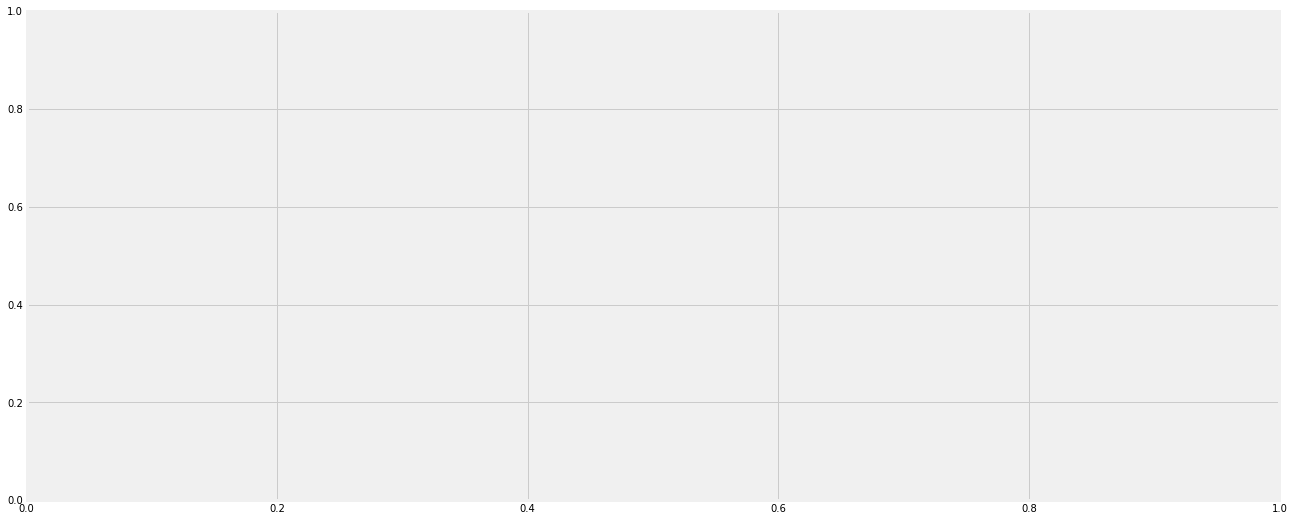

In [9]:
pd.plot(figsize=(20,9), subplots=False)